In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
from training_utils import CIFAR10_dataloaders, training_monitor, print_model_size

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [2]:
# Helper module that sums the output of the main branch and the skip branch.
class Residual(nn.Module):
    def __init__(self, main, skip):
        super().__init__()
        self.main = main
        self.skip = skip

    def forward(self, x):
        return self.main(x) + self.skip(x)

# BasicBlock defined entirely with nn.Sequential
class BasicBlock(nn.Module):
    expansion = 1  # For compatibility with ResNet architectures.

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        # Main branch: two 3x3 convolutions with BatchNorm and ReLU (only after the first conv)
        main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        # Skip branch: downsample if needed; otherwise, identity.
        if stride != 1 or in_channels != out_channels:
            skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            skip = nn.Identity()
        # Combine the main and skip branches, then apply the final ReLU.
        self.block = nn.Sequential(
            Residual(main, skip),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

In [3]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            # Initial convolutional block for CIFAR‑10.
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # Layer 1: two BasicBlocks (no downsampling)
            BasicBlock(64, 64, stride=1),
            BasicBlock(64, 64, stride=1),
            # Layer 2: two BasicBlocks, with downsampling on the first block.
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128, stride=1),
            # Layer 3: two BasicBlocks, with downsampling on the first block.
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256, stride=1),
            # Layer 4: two BasicBlocks, with downsampling on the first block.
            BasicBlock(256, 512, stride=2),
            BasicBlock(512, 512, stride=1),
            # Global average pooling, flattening, and final linear classifier.
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

In [4]:
print_model_size(ResNet())

Total params = 1.117396e+07
Trainable params = 1.117396e+07


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/30 [00:00<?, ?it/s]

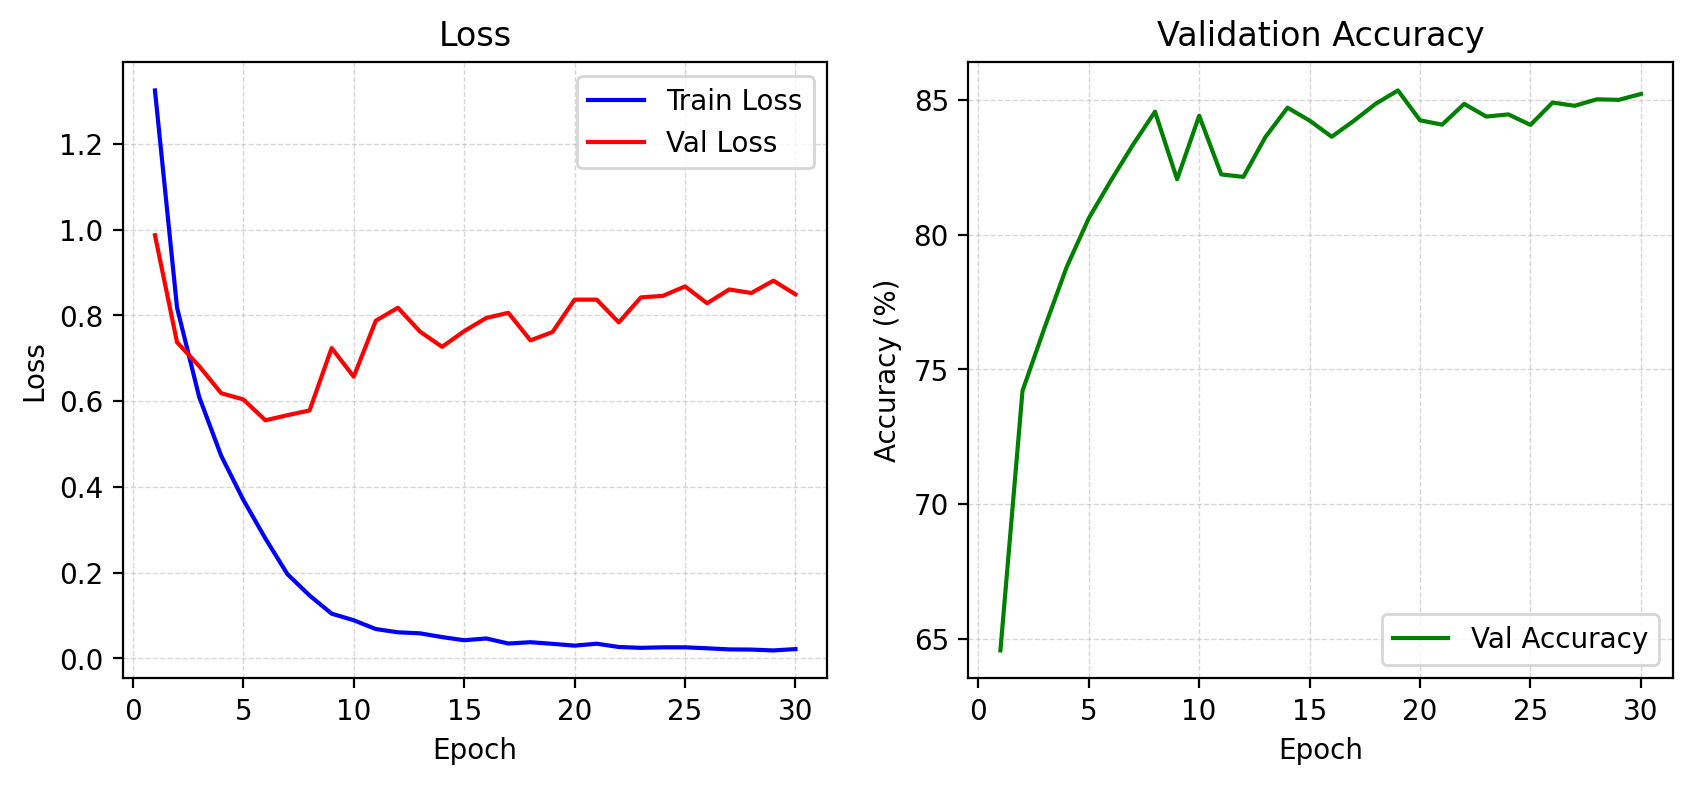

Epoch 30/30: 100%|##########| 30/30 [25:31<00:00, 22.19s/it]

|       Epoch        |     Train loss     |  Validation loss   | Validation accuracy, %  |
__________________________________________________________________________________________
|         1          |       1.3247       |       0.9870       |         64.5600         |
|         2          |       0.8181       |       0.7372       |         74.2000         |
|         3          |       0.6102       |       0.6818       |         76.5500         |
|         4          |       0.4725       |       0.6185       |         78.8000         |
|         5          |       0.3699       |       0.6041       |         80.6100         |
|         6          |       0.2797       |       0.5554       |         82.0100         |
|         7          |       0.1964       |       0.5673       |         83.3400         |
|         8          |       0.1468       |       0.5784       |         84.5700         |
|         9          |       0.1044       |       0.7238       |         82.0600         |

In [5]:
trainloader, testloader, classes = CIFAR10_dataloaders(batch_size=64)

model = ResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

trained_model = training_monitor(device, model, optimizer, criterion, num_epochs, trainloader, testloader)
